# Master-Thesis 

Summary:  
Find mysterious soil property corresponding to soil-moisture behaviours. First Idea is to look at soil-moisture content after a minimum of 10 mm precipitation occured. Analyse the drying behaviours of the soil in the dry period after the rain event. 

# Table-of-content  

[AOI](#AOI)  



## Modul imports

In [4]:
import pprint
pp = pprint.PrettyPrinter(indent=2) # for printing pretty idk what it is... print with pp.pprint(print stuff)
import ipyleaflet
from ipyleaflet import Map, GeoJSON, basemaps, Popup, LayersControl
from ipywidgets import HTML
from IPython.display import Image, IFrame
import ee
ee.Initialize()

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import dates
import altair as alt
from sklearn import cluster
from skimage import io, morphology, measure
from osgeo import gdal, gdal_array
gdal.UseExceptions()
gdal.AllRegister()


In [6]:
import os
import datetime
import numpy as np
import geopandas as gpd
from shapely.geometry import shape

## Functions

In [7]:
#Get TileLayerurl from ee to plot on ipyleaflet
def GetTileLayerUrl(ee_image_object):
    map_id = ee.Image(ee_image_object).getMapId()
    tile_url_template = "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
    return tile_url_template.format(**map_id)

def clip_aoi(ImageCollection):
    im = ImageCollection.clip(ried_225_222)
    return im

# AOI

The area of interest is the hessisches Ried. The shape is digitized from a screnshot taken from http://atlas.umwelt.hessen.de/servlet/Frame/atlas/naturschutz/naturraum/karten/m_3_2_1.htm . I found no better source. Info: The HLNUG is selling this shapes there's no open source map.

In [8]:
# Load AOI from GEE as FeatureCollection
ried_225_222 = ee.FeatureCollection('users/tillmueller1990/ried_225_222') # Use this but the boundary isn't that precise at borders, got it from wms layer 

#Get geometry and convert it to GeoJSON for visualisation purpose 
ried_geometry = ried_225_222.geometry().getInfo() #dict object
ried_geometry = ee.Geometry.Polygon(ried_geometry['coordinates']) #cast to Geometry object
ried_JSON = ried_geometry.toGeoJSON() #get GeoJSON object

#get area of aoi
ried_area = ried_225_222.geometry().area().getInfo()
print("Hessisches Ried: Naturräumliche Einheiten 225 und 222, area: ca. ", ried_area/1000**2, "km²") #m² in km² 

#map properties
center, zoom = (49.7252978589571, 8.34580993652344), 9

#create basemap
map_aoi = Map(center = center, zoom = zoom, basemap=basemaps.Esri.NatGeoWorldMap)

#add Layer to map
ried = GeoJSON(data = ried_JSON, style = {'color': 'blue', 'opacity':1, 'fillOpacity':0.25}) #Create GeoJSON ipyleaflet object
map_aoi.add_layer(ried) #add layer to map

#display map
map_aoi


Hessisches Ried: Naturräumliche Einheiten 225 und 222, area: ca.  725.892726964547 km²


Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{…

# Remote sensed data

This work try to obtain the most data from osm remotely sensed products or self derived data.  
There are many properties affecting soil moisture:  
1. Soil type  (X)
2. Organic content  ( )
3. Precipitation  (X)
4. Vegetation  (X)
5. Altitude  (X)
6. Sun radiation (X)
7. Cloudcover  ( )
8. Soil temperature (X)
9. Air temperature (X)
10. Evaporation / Evapotranspiration (X)
11. Wind relation (X)
12. ? ( )

A brief overview of available datasets:  

### Earth Engine Datasets
#### NASA-USDA Global Soil Moisture Data https://developers.google.com/earth-engine/datasets/catalog/NASA_USDA_HSL_soil_moisture
revesit : 3days ; resoltion : 0.25 arc degrees (~25km)
Surface soil moisture  
Subsurface soil moisture  
Soil moisture profile  
Surface soil moisture anomaly  
Subsurface soil moisture anomaly  
#### CHIRPS Daily: Climate Hazards Group InfraRed Precipitation with Station Data https://developers.google.com/earth-engine/datasets/catalog/UCSB-CHG_CHIRPS_DAILY
revesit : daily ; resolution : 0.05 arc degrees (~5km)  
precipitation mm 
####  GLDAS-2.1: Global Land Data Assimilation System https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V021_NOAH_G025_T3H
revesit : 3 H , resolotion : 0.25 arc degrees (~25km)  
Albedo  
Average surface skin temperature  
Plant canopy surface water  
Canopy water evaporation  
Direct evaporation from bare soil  
Evapotranspiration  
Downward long-wave radiation flux  
Net long-wave radiation flux  
Potential evaporation rate  
Pressure 
Specific humidity  
Heat flux  
Sensible heat net flux  
Latent heat net flux  
Storm surface runoff  
Baseflow-groundwater runoff  
Snow melt  
Total precipitation rat  
Rain precipitation rate  
Root zone soil moisture  
Snow depth water equivalent  
Downward short-wave radiation flux  
Snow depth  
Snow precipitation rate  
Soil moisture  
Soil temperature  
Net short wave radiation flux  
Air temperature  
Transpiration  
Wind speed  

####  Corine Land Cover 
Year: 2012, resolution: 100m

### Other Datasets

#### Bodenübersichtskarte von Hessen http://bodenviewer.hessen.de/mapapps/resources/apps/bodenviewer/index.html?lang=de
Year: 1997, scale: 1 : 500 000 bis zu 1:5000 




# Soil Type
Soil type is important because different kind of soils have different potentials to release water at same weather conditions.   
![Image of Yaktocat](http://www.soilmanagementindia.com/wp-content/uploads/2017/03/clip_image002-5.jpg)  

I found no source for downloading a soil map in any format there are only wms layer and bodenviewer of HLNUG so i take a screenshot from HLNUG Bodenviewe.  
The smallest scale fits on one screenshot. The other two scales (1:50.000 and 1:5.000) need several screenshots. Than you have to stich the images with e.g. autosticht together.  

In [38]:
IFrame(src='http://bodenviewer.hessen.de/mapapps/resources/apps/bodenviewer/index.html?lang=de&center=550000%2C5595000%2C25832&lod=3', width=1400, height=600)

## All Band Classifier (KMeans)
Save this images as .tiff or .png to preserve the 3 bands. Because we need to make a KMeans classification and with more bands the classification is better. The number of possible soil classes are 32 + 1 for the white background. 

[[ 0  0  0 ...  0  0 32]
 [ 0  0  0 ...  0  0 32]
 [ 0  0  0 ...  0  0 32]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
Color: [255. 255. 255.]  >>  Objects: 1
Color: [232. 192. 164.]  >>  Objects: 56
Color: [255. 196.  77.]  >>  Objects: 186
Color: [239. 210. 255.]  >>  Objects: 40
Color: [255. 225. 166.]  >>  Objects: 127
Color: [183. 230. 246.]  >>  Objects: 108
Color: [223. 161. 115.]  >>  Objects: 9
Color: [255. 197. 210.]  >>  Objects: 229
Color: [233. 157. 255.]  >>  Objects: 62
Color: [238. 222.  77.]  >>  Objects: 73
Color: [248. 217. 113.]  >>  Objects: 56
Color: [248. 162. 204.]  >>  Objects: 53
Color: [136. 255.  77.]  >>  Objects: 28
Color: [216. 210. 178.]  >>  Objects: 85
Color: [173. 140. 125.]  >>  Objects: 4
Color: [238. 183.  77.]  >>  Objects: 33
Color: [195. 155.  77.]  >>  Objects: 16
Color: [216. 174. 153.]  >>  Objects: 22
Color: [220. 220. 148.]  >>  Objects: 11
Color: [214. 122. 210.]  >>  Objects: 10
Color: [220. 220. 220.]

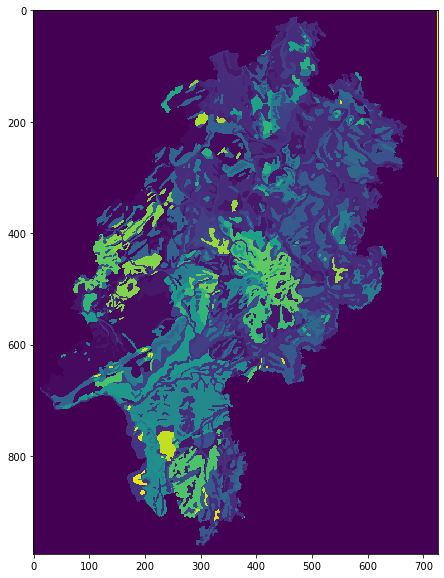

In [28]:
filepath = r'C:\Users\USER\Desktop\master-thesis-master\soil_map\results\great_hesse_soil_map_ref.tif'

#Load file in gdal
file = gdal.Open(filepath, gdal.GA_ReadOnly)

#Initialize an array of zeros with size of input
img = np.zeros((file.RasterYSize, file.RasterXSize, file.RasterCount), gdal_array.GDALTypeCodeToNumericTypeCode(file.GetRasterBand(1).DataType))

#Loop over the number of bands in the image (img.shape[2]) insert values into the numpy array
for b in range(img.shape[2]):
    img[ : , : , b] = file.GetRasterBand(b + 1).ReadAsArray()

#Reshape array 
new_shape = (img.shape[0] * img.shape[1], img.shape[2])

#based on this shape, we can build the input value
X = img[: , : , :3].reshape(new_shape)
#X = np.where(X==150, 255, X) Bad idea because other r ,g or b values may have same as black and gray
#X = np.where(X==0, 255, X) 

#Classifier Kmeans
k_means = cluster.KMeans(n_clusters=33)
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

#Get statistic values
for i in np.unique(X_cluster):
    blobs = np.int_(morphology.binary_opening(X_cluster == i))
    color = np.around(k_means.cluster_centers_[i])
    count = len(np.unique(measure.label(blobs))) - 1
    print('Color: {}  >>  Objects: {}'.format(color, count))
    
#Plot the data
plt.figure(figsize=(20,10))
plt.imshow(X_cluster)

plt.show()


## Save Classification as GeoTiff 

In [ ]:
#Open input image again to get properties
file = gdal.Open(filepath)

#We need a single band
band = file.GetRasterBand(1)

#Convert it to an array
arr = band.ReadAsArray()

#Extract columns and rows to a list
[cols, rows] = arr.shape

#Set the output as Geotiff
format = "GTiff"
driver = gdal.GetDriverByName(format)

#Creates the output raster with the dimensions of the input raster
#outDataRaster = driver.Create("soil_map_hesse_classify_33.tiff", rows, cols, 1, gdal.GDT_Byte) -> activate this cell for saving image local

#Set the projection and extent of the data.
outDataRaster.SetGeoTransform(file.GetGeoTransform())##sets same geotransform as input
outDataRaster.SetProjection(file.GetProjection())##sets same projection as input

#Write classification result to a single band raster image 
outDataRaster.GetRasterBand(1).WriteArray(X_cluster)

#Calling FlushCache() to remove from memory and delete the data
outDataRaster.FlushCache() ## remove from memory
del outDataRaster ## delete the data (not the actual geotiff)

## Analyse Soil Types within Hessisches Ried

Create Features for different soil types to compare soil-moisture. 

In [23]:
#Load Soil Types from BÜK 1:500.000 and clip to AOI
soil_map_great = ee.Image('users/tillmueller1990/soil_map_hesse_classify_33').clip(ried_225_222)

#Mask out Background 
mask = soil_map_great.neq(1) #Value 1 is invalid its the background (white) from screenshot 
soil_map_great = soil_map_great.updateMask(mask) #Apply Mask

#Get Unique values to check if every value is signed correctly 
soil_map_great_uniqueValues = soil_map_great.reduceRegion(reducer=ee.Reducer.countDistinct(), geometry=ried_geometry, scale= 100 ,maxPixels= 1e10)
print("soil_map_great_uniqueValues", soil_map_great_uniqueValues.getInfo())

#Correct raster values to corresponding soil class values 
soil_map_great = soil_map_great.where(soil_map_great.eq(14),1) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(12),13) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(3),2) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(31),3) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(19),4) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(25),34) ## 
soil_map_great = soil_map_great.where(soil_map_great.eq(7),25) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(9),7) ## 
soil_map_great = soil_map_great.where(soil_map_great.eq(5),9) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(8),5) ##
soil_map_great = soil_map_great.where(soil_map_great.eq(0),8) ##

#get area for each class
class_areas = ee.Image.pixelArea().divide(1000*1000).addBands(soil_map_great).reduceRegion(reducer= ee.Reducer.sum().group(groupField= 1,groupName= 'Soil class'),geometry=ried_geometry,scale= 265, maxPixels= 1e10).get('groups') # sample the geometry at 1m intervals;
pp.pprint(class_areas.getInfo())

#clip to clc landcover classes to avoid measuering over citys, forest or other dense vegetation
soil_map_great_clc = soil_map_great.clip(clc_vector)

#Convert an image to a feature collection by reducing homogenous regions ->>>>> Hier nochmal nachschauen man muss die ganzen winzigen Features rausfiltern ....
soil_map_great_labeled = soil_map_great_clc.connectedComponents(ee.Kernel.plus(1),250) #Finds connected components with the same value of the first band of the input and labels them with a globally unique value.
soil_map_great_scale = soil_map_great_labeled.projection().nominalScale().getInfo() #get scale parameter 
features_clc = soil_map_great_labeled.reduceToVectors(reducer = ee.Reducer.first(), geometry= ried_geometry, scale= 265, geometryType= 'Polygon', eightConnected= False,maxPixels= 1e10) #FeatureCollection of patches

def add_area_to_FC(feature):
    return feature.set('area',  feature.geometry().area(1).divide(1000*1000))

features_clc = features.map(add_area_to_FC)
#pp.pprint(features.getInfo())

#Grouped a count reducer: count number of land cover category pixels by patches
count = soil_map_great_labeled.select(['labels','b1']).reduceRegion(reducer= ee.Reducer.count().group(groupField= 0, groupName= 'label'), geometry= ried_geometry, scale= 265,  maxPixels= 1e8)
pp.pprint(count.getInfo())

#Get test field for biggest area of soil class
#class_1 = features.filterMetadata('label','equals',)

#Create LookUp Table for raster values corresponding to the soil type 
soil_types_legend = {1:'Niedermoore, Hochmoore', 2:'Vega, Auengleye, örtl. Anmoorgleye', 3:'Tschernoseme', 4:'Parabraunerden', 5:'Braunerden mit Bändern, Bänder-Parabraunerden, örtl. Podsol-Braunerden', 7:'Pararendzinen, Braunerden mit Bändern, örtl. Bänder-Parabraunerden', 8:'Braunerden mit Bändern, Bänder-Parabraunerden, örtl. Podsol-Braunerden', 9:'Pararendzinen', 13: 'Parabraunerden, örtl. Pseudogley-Parabraunerden',25: 'Braunerden, Ranker-Braunerden, Regosol-Braunerden' , 34 : 'Braunerden, Braunerde-Pseudogleye, örtl. Podsol-Braunerden'} #Legende
raster_value_soil_value = {14:1, 3:2, 31:3, 19:4, 25:34, 7:25, 9:7 ,8:5, 9:7 , 0:8, 5:9 } # Value in raster value of legend



soil_map_great_uniqueValues {'b1': 12}
[ {'Soil class': 1, 'sum': 54.134680807843544},
  {'Soil class': 2, 'sum': 167.6488250538931},
  {'Soil class': 3, 'sum': 32.093248070312406},
  {'Soil class': 4, 'sum': 178.89962462814134},
  {'Soil class': 5, 'sum': 113.95033903416072},
  {'Soil class': 7, 'sum': 83.83647987366727},
  {'Soil class': 8, 'sum': 53.012483863281744},
  {'Soil class': 9, 'sum': 18.597190235692402},
  {'Soil class': 13, 'sum': 1.0604802034160539},
  {'Soil class': 25, 'sum': 5.034909453446693},
  {'Soil class': 34, 'sum': 17.59305870199146}]
{ 'groups': [ {'count': 1, 'label': 725849473779},
              {'count': 1, 'label': 725849473780},
              {'count': 1, 'label': 730144441071},
              {'count': 1, 'label': 730144441072},
              {'count': 1, 'label': 730144441073},
              {'count': 1, 'label': 730144441075},
              {'count': 1, 'label': 730144441079},
              {'count': 1, 'label': 734439408365},
              {'count': 1,

In [24]:
#create basemap
map_s = Map(center = center, zoom = zoom, basemap=basemaps.Esri.NatGeoWorldMap)

#soil color map
soil_color_dict = {1:'87FF4B', 2:'B5E6F5', 3:'D8A56D', 4:'C1994B', 5:'EDB74B', 7:'FFD1EE', 8:'FFE0A5', 9:'E99DFF',13:'FFBA43',25:'FFC3D1',34:'EECEA1'}
soil_color_list = list(soil_color_dict.values())
#add Layer to map
soil_map_great_viz = GetTileLayerUrl(soil_map_great.visualize(min=0, max=10, palette=soil_color_list)) #Create GeoJSON ipyleaflet object
soil_map_great_layer = ipyleaflet.TileLayer(url=soil_map_great_viz,name='soil_map_great')

soil_map_great_patches_viz = GetTileLayerUrl(features_clc.draw(color='red').visualize())
soil_map_great_patches_layer = ipyleaflet.TileLayer(url=soil_map_great_patches_viz, name='soil_class features')

map_s.add_layer(soil_map_great_layer) #add layer to map
map_s.add_layer(soil_map_great_patches_layer) #add layer to map

#display map
map_s.add_control(LayersControl())
map_s

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{…

soil_map_great_histogram {1.0: 773.7843137254902, 2.0: 2385.023529411763, 3.0: 459.0, 4.0: 2549.854901960784, 5.0: 1612.2980392156862, 7.0: 1190.8549019607844, 8.0: 760.5921568627449, 9.0: 264.87450980392157, 13.0: 14.529411764705882, 25.0: 69.15686274509805, 34.0: 249.26666666666662}


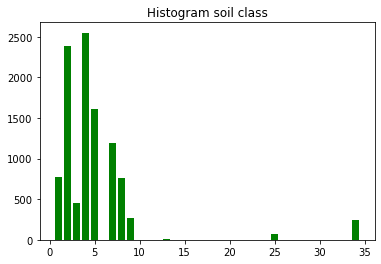

In [22]:
#Make Histogram
def get_histogram_from_image(image):
    dict_histogram = image.reduceRegion(reducer=ee.Reducer.autoHistogram(), geometry=ried_geometry, scale= 265,maxPixels= 1e10).getInfo()['b1']
    keys = [x[0] for x in dict_histogram if x[1] > 0.0]  #get keys from [key,value] list if value is > 0
    values = [x[1] for x in dict_histogram if x[0] in keys] #get values for keys if the key is in value
    return dict(zip(keys,values))

histogram_soil_map_great = get_histogram_from_image(soil_map_great)
print("soil_map_great_histogram", histogram_soil_map_great)

plt.bar(histogram_soil_map_great.keys(), histogram_soil_map_great.values(), color='g')
plt.title("Histogram soil class")
plt.show()

In [39]:
#In order to analyse the soil-moisture content we need to know more about the landuse and landcover. We are interested in fields with less or no vegetation.   


['labels', 'b1']
{ 'groups': [ {'count': 503, 'patch id': 2005749729182},
              {'count': 6766, 'patch id': 2005749729185},
              {'count': 7, 'patch id': 2010044696476},
              {'count': 127, 'patch id': 2014339663770},
              {'count': 200, 'patch id': 2104533977025},
              {'count': 519, 'patch id': 2130303780806},
              {'count': 467, 'patch id': 2207613192426},
              {'count': 3164, 'patch id': 2211908159388},
              {'count': 1560, 'patch id': 2220498093978},
              {'count': 6, 'patch id': 2220498094266},
              {'count': 550, 'patch id': 2229088028633},
              {'count': 2006, 'patch id': 2263447767181},
              {'count': 552, 'patch id': 2263447767223},
              {'count': 852, 'patch id': 2276332669101},
              {'count': 6568, 'patch id': 2319282341985},
              {'count': 46, 'patch id': 2357937047494},
              {'count': 716, 'patch id': 2357937047502},
              

## Soil moisture from Sentinel 1 
Here i try to derive soil moisture content from SAR data hostet on Google Earth Engine. The algorithm is a simple Change Detection Method more to this later....

In [11]:
#Sentinel 1 backscatter raw data convertet to reflectivity range between 0 and 1 indicator for high reflectivity = high water volume content and vis verse 
#Load Sentinel 1 and filter data
def load_dataset(ImageCollection_ID,begin,end,aoi):
    ic = ee.ImageCollection(ImageCollection_ID).filterDate(begin,end).filterBounds(aoi)
    return ic

def filter_sentinel1(ImageCollection,polarisation,instrumentMode,resolution):
    ic = ImageCollection.filter(ee.Filter.listContains('transmitterReceiverPolarisation',polarisation)).filter(ee.Filter.eq('instrumentMode',instrumentMode)).filterMetadata('resolution_meters','equals', resolution)
    return ic

def seperate_look_angels(ImageCollection):
    Ascending = ImageCollection.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
    Descending = ImageCollection.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
    return Ascending,Descending

def seperate_tiles(ImageCollection,tiles):
    tile_list = [x]

def get_geometry(ImageCollection):
    geometry = ImageCollection.geometry().getInfo()
    #geometry = [x for x in geometry['coordinates']]
    return geometry

def show_tiles(ImageCollection):
    geometry = get_geometry(ImageCollection)
    geometry_list = list(geometry['coordinates'])
    flattened_list = [y for x in geometry_list for y in x] #De flatter list 
    unique_list = []
    unique_list = [x for x in flattened_list if x not in unique_list]
    print("different tiles: ",len(unique_list))
    m = Map(center=(49.6252978589571, 8.34580993652344), zoom=7)
    geo_json = GeoJSON(data=geometry, style = {'color': 'green', 'opacity':1, 'weight':1.9, 'dashArray':'9', 'fillOpacity':0.1})
    m.add_layer(geo_json)
    dc = ipyleaflet.DrawControl()
    m.add_control(dc)
    m.add_control(LayersControl())
    return m
    
def get_properties(ImageCollection):
    features = ImageCollection.getInfo()['features']
    dict_list = []
    for f in features:
        prop = f['properties']
        dict_list.append(prop)
    df = pd.DataFrame.from_records(dict_list).drop(['system:footprint','transmitterReceiverPolarisation'],axis=1)
    #Pandas Series of unique distinc values in df
    unique = df.nunique()
    im_id_list = [item.get('id') for item in ImageCollection.getInfo().get('features')]
    date_list = [datetime.datetime.strptime(x[35:43],'%Y%m%d') for x in im_id_list]
    #property_names = list(df.columns.values) 
    return unique, im_id_list, date_list

def make_mosaic(date,ImageCollection):
    date = ee.Date(date['value'])
    filterCollection = ImageCollection.filterDate(date, date.advance(1,'day'))
    #Make the mosaic
    image = ee.Image(filterCollection.mosaic()).copyProperties(filterCollection.first(),["system:time_start"])
    #Add the mosaic to a list only if the collection has images
    #return ee.List(ee.Algorithms.If(filterCollection.size(), newList.add(image), newList))
    return image

def clip_aoi(ImageCollection):
    im = ImageCollection.clip(ried_225_222)
    return im

def add_area(image):
    area = image.multiply(ee.Image.pixelArea()).divide(-(1000*1000))
    stat = area.reduceRegion(ee.Reducer.sum(),ried_225_222,10) 
    im = image.set('area',stat.get('VV'))
    return im

def reproject(image):
    VV = image.select('VV')
    return image.reporject({crs: VV.projection().crs(), scale : 100})

def toNatural(image):
    return ee.Image(10.0).pow(image.select(0).divide(10.0)).copyProperties(image)

def toDB(image):
    return ee.Image(image).log10().multiply(10.0).copyProperties(image)

#Sigma Lee speckle filteringThe RL speckle filter from https://code.earthengine.google.com/2ef38463ebaf5ae133a478f173fd0ab5 by Guido Lemoine
def RefinedLee(img):
    #img must be in natural units, i.e. not in dB!
    #Set up 3x3 kernels
    weights3 = ee.List.repeat(ee.List.repeat(1,3),3)
    kernel3 = ee.Kernel.fixed(3,3, weights3, 1, 1, False)
    mean3 = img.reduceNeighborhood(ee.Reducer.mean(), kernel3)
    variance3 = img.reduceNeighborhood(ee.Reducer.variance(), kernel3)
    #Use a sample of the 3x3 windows inside a 7x7 windows to determine gradients and directions
    sample_weights = ee.List([[0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0], [0,1,0,1,0,1,0], [0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0]])
    sample_kernel = ee.Kernel.fixed(7,7, sample_weights, 3,3, False)
    #Calculate mean and variance for the sampled windows and store as 9 bands
    sample_mean = mean3.neighborhoodToBands(sample_kernel)
    sample_var = variance3.neighborhoodToBands(sample_kernel)
    #Determine the 4 gradients for the sampled windows
    gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs()
    gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs())
    gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs())
    gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs())
    #And find the maximum gradient amongst gradient bands
    max_gradient = gradients.reduce(ee.Reducer.max())
    #Create a mask for band pixels that are the maximum gradient
    gradmask = gradients.eq(max_gradient)
    #duplicate gradmask bands: each gradient represents 2 directions
    gradmask = gradmask.addBands(gradmask)
    #Determine the 8 directions
    directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1)
    directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2))
    directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3))
    directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4))
    #The next 4 are the not() of the previous 4
    directions = directions.addBands(directions.select(0).Not().multiply(5))
    directions = directions.addBands(directions.select(1).Not().multiply(6))
    directions = directions.addBands(directions.select(2).Not().multiply(7))
    directions = directions.addBands(directions.select(3).Not().multiply(8))
    #Mask all values that are not 1-8
    directions = directions.updateMask(gradmask)
    #"collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
    directions = directions.reduce(ee.Reducer.sum())
    #Generate stats
    sample_stats = sample_var.divide(sample_mean.multiply(sample_mean))
    #Calculate localNoiseVariance
    sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0])
    #Set up the 7*7 kernels for directional statistics
    rect_weights = ee.List.repeat(ee.List.repeat(0,7),3).cat(ee.List.repeat(ee.List.repeat(1,7),4))
    #Set weights
    diag_weights = ee.List([[1,0,0,0,0,0,0], [1,1,0,0,0,0,0], [1,1,1,0,0,0,0],[1,1,1,1,0,0,0], [1,1,1,1,1,0,0], [1,1,1,1,1,1,0], [1,1,1,1,1,1,1]])
    rect_kernel = ee.Kernel.fixed(7,7, rect_weights, 3, 3, False)
    diag_kernel = ee.Kernel.fixed(7,7, diag_weights, 3, 3, False)
    #Create stacks for mean and variance using the original kernels Mask with relevant direction.
    dir_mean = img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1))
    dir_var = img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1))
    dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(),diag_kernel).updateMask(directions.eq(2)))
    dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(),diag_kernel).updateMask(directions.eq(2)))
    #and add the bands for rotated kernels
    for i in range(4):
        dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(),rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
        dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(),rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
        dir_mean = dir_mean.addBands(img.reduceNeighborhood(ee.Reducer.mean(),diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
        dir_var = dir_var.addBands(img.reduceNeighborhood(ee.Reducer.variance(),diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
    #"collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
    dir_mean = dir_mean.reduce(ee.Reducer.sum())
    dir_var = dir_var.reduce(ee.Reducer.sum())
    #A finally generate the filtered value
    varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))
    b = varX.divide(dir_var)
    result = dir_mean.add(b.multiply(img.subtract(dir_mean)))
    return result.arrayFlatten([['VV']]).copyProperties(img)

def calc_asc_soilMoisture(image):
    im = image.expression('(omega - omegaD) / (omegaW - omegaD)', {'omega' : image.select('VV'), 'omegaD' : minMax_asc.select('VV_max'), 'omegaW' : minMax_asc.select('VV_min')})
    return im.addBands(im).select(['VV','VV_1'],['Backscatter_Coefficient','soil_moisture_content'])

def calc_des_soilMoisture(image):
    im = image.expression('(omega - omegaD) / (omegaW - omegaD)', {'omega' : image.select('VV'), 'omegaD' : minMax_des.select('VV_max'), 'omegaW' : minMax_des.select('VV_min')})
    return im.addBands(im).select(['VV','VV_1'],['Backscatter_Coefficient','soil_moisture_content'])

def filter_IC(ImageCollection,filter):
    old_size = ImageCollection.size().getInfo()
    new_coll = ImageCollection.filter(filter)
    new_size = new_coll.size().getInfo()
    return new_coll

def reducer(ImageCollection,reducer):
    im = ImageCollection.reduce(reducer)
    return im

def plot_image(ImageCollection):
    m = Map(center=(49.6252978589571, 8.34580993652344), zoom=7)
    ic = GetTileLayerUrl(ImageCollection.first().visualize())
    m.add_layer(ic)
    dc = ipyleaflet.DrawControl()
    m.add_control(dc)
    m.add_control(LayersControl())
    return m

def windy_days_filter(image):
    d = image.date().format('Y-M-d')
    wx = ee.ImageCollection('NOAA/CFSV2/FOR6H')
    vWind = wx.select(['v-component_of_wind_height_above_ground'])
    a = vWind.max()
    uWind = wx.select(['u-component_of_wind_height_above_ground'])
    b = uWind.max()
    a = a.pow(2)
    b = b.pow(2)
    ab = a.add(b)
    ws = ab.sqrt()
    ws = ws.multiply(3.6)
    return image.updateMask(ws.lt(12))

#Time of interest
begin = ee.Date.fromYMD(2013,1,1)
end = ee.Date.fromYMD(2019,6,1)
date_range = end.difference(begin, 'day')

#Source dataset
sentinel1 = load_dataset('COPERNICUS/S1_GRD',begin,end,ried_225_222)
print("sentinel1",type(sentinel1),"Collection Size: ", sentinel1.size().getInfo())

#Filter dataset for High resolution and Vertical transmitt vertical receive
sentinel1_VV = filter_sentinel1(sentinel1,'VV','IW',10)
print("sentinel1_VV",type(sentinel1_VV),"Collection Size: ", sentinel1_VV.size().getInfo())

print(sentinel1_VV.first().propertyNames().getInfo())
#The RL speckle filter from https://code.earthengine.google.com/2ef38463ebaf5ae133a478f173fd0ab5 by Guido Lemoine
sentinel1_VV_natural = sentinel1_VV.map(toNatural)
#print(sentinel1_VV_natural.first().propertyNames().getInfo())
sentinel1_VV_slFilter = sentinel1_VV_natural.map(RefinedLee)
#print(sentinel1_VV_slFilter.first().propertyNames().getInfo())                      
sentinel1_VV = sentinel1_VV_slFilter.map(toDB)
#print(sentinel1_VV.first().bandNames().getInfo())
#print(sentinel1_VV.first().propertyNames().getInfo())

#Filter for different look angles
VV_Ascending,VV_Descending = seperate_look_angels(sentinel1_VV)
print("VV_Ascending",type(VV_Ascending),"VV_Descending",type(VV_Descending),"Collection Size: ", VV_Ascending.size().getInfo(), VV_Descending.size().getInfo())

#Clip images to AOI and calculate area property
VV_aoi_asc = VV_Ascending.map(clip_aoi).map(add_area)
print("VV_aoi_asc",type(VV_aoi_asc),"Collection Size: ", VV_aoi_asc.size().getInfo())
VV_aoi_des = VV_Descending.map(clip_aoi).map(add_area)
print("VV_aoi_des",type(VV_aoi_des),"Collection Size: ", VV_aoi_des.size().getInfo())

#Create Min and Max bands for change detection method
minMax_asc = reducer(VV_aoi_asc,ee.Reducer.minMax())
print("minMax_asc",type(minMax_asc),minMax_asc.getInfo())
minMax_des = reducer(VV_aoi_des,ee.Reducer.minMax())
print("minMax_des",type(minMax_des),minMax_des.getInfo())

#Compute soil moisture with simple change detection Methode
VV_asc_sm = VV_aoi_asc.map(calc_asc_soilMoisture)
print("VV_asc_sm",type(VV_asc_sm),"Collection Size: ", VV_asc_sm.size().getInfo())
VV_des_sm = VV_aoi_des.map(calc_des_soilMoisture)
print("VV_des_sm",type(VV_des_sm),"Collection Size: ", VV_des_sm.size().getInfo())

sentinel1 <class 'ee.imagecollection.ImageCollection'> Collection Size:  1160
sentinel1_VV <class 'ee.imagecollection.ImageCollection'> Collection Size:  1128
['GRD_Post_Processing_start', 'sliceNumber', 'system:id', 'GRD_Post_Processing_facility_name', 'resolution', 'SLC_Processing_facility_name', 'system:footprint', 'familyName', 'system:version', 'segmentStartTime', 'missionDataTakeID', 'GRD_Post_Processing_facility_country', 'nssdcIdentifier', 'productClass', 'phaseIdentifier', 'orbitProperties_pass', 'relativeOrbitNumber_stop', 'system:time_end', 'SLC_Processing_facility_site', 'GRD_Post_Processing_stop', 'system:time_start', 'instrumentMode', 'totalSlices', 'SLC_Processing_stop', 'startTimeANX', 'SLC_Processing_start', 'resolution_meters', 'instrumentSwath', 'relativeOrbitNumber_start', 'productTimelinessCategory', 'SLC_Processing_software_name', 'sliceProductFlag', 'S1TBX_Calibration_vers', 'orbitNumber_start', 'GRD_Post_Processing_facility_site', 'instrument', 'GRD_Post_Process

### Get compareable test fields of soil classes
Because it is not usefull to measure the sm content in areas of city, urban and forest we have to find bare or crop land or other spare vegetation land.  
To find these areas there are two methods:  
1. Is to detect these landclasses by a indice like ndvi, ndbi...., 
2. use existing data products like the corine land cover classification 

## Corine Land Cover (CLC) 

In [20]:
# Load last corine land cover image 
clc = ee.Image.load('COPERNICUS/CORINE/V18_5_1/100m/2012', -1)

# Mask areas where soil moisture measurements valid (farmland cat.:11-16)
clc_mask = clc.gte(11).And(clc.lte(16)) #binary map for updateMask
clc = clc.updateMask(clc_mask) #set mask for not Farmland

# Clip to extend of Hessisches Ried
clc_image = clc.clip(ried_225_222) #image

# Feature Collection of clc farmland cat.: 11-16 with 350m resolution
clc_vector = clc.reduceToVectors(geometry=ried_225_222, crs=clc.projection(), scale=100, geometryType='polygon', eightConnected = True) #FeatureCollection

In [15]:
# ==========================================================================
# Function to Convert Feature Classes to Pandas Dataframe
# Adapted from: https://events.hpc.grnet.gr/event/47/material/1/12.py https://gis.stackexchange.com/questions/257727/iterate-over-imagecollection-returning-pandas-dataframe-using-earth-engine-pyt
def fc2df(fc):
    # Convert a FeatureCollection into a pandas DataFrame
    # Features is a list of dict with the output
    features = fc.getInfo()['features']

    dictarr = []

    for f in features:
        # Store all attributes in a dict
        attr = f['properties']
        # and treat geometry separately
        attr['geometry'] = f['geometry']  # GeoJSON Feature!
        # attr['geometrytype'] = f['geometry']['type']
        dictarr.append(attr)

    df = gpd.GeoDataFrame(dictarr)
    # Convert GeoJSON features to shape
    df['geometry'] = map(lambda s: shape(s), df.geometry)    
    return df

# ==========================================================================
# Function to iterate over image collection, returning a pandas dataframe
def extract_point_values(img_id, pts):
    IC = soil_moisture_1.filterMetadata('system:index', 'equals', img_id)
    image = IC.reduce(ee.Reducer.mean())
    fc_image_redR = image.reduceRegions(collection=pts,
                                  reducer=ee.Reducer.mean(),
                                  scale=250,
                                  crs = proj)

    # Convert to Pandas Dataframe
    df_image_red = fc2df(fc_image_redR)

    # Add Date as Variable
    df_image_red['date'] = datetime.datetime.strptime(img_id[33:48],'%Y%m%dT%H%M%S')
    return df_image_red

# ==========================================================================
#### Features
features_f = features.filterMetadata('area','greater_than',1)

#### Projection
proj = ee.Projection('EPSG:4326')

#### Load Raster
soil_moisture_1 = VV_asc_sm.select('soil_moisture_content')

#### Make list of image IDs and Dates
sm_1_id = [item['properties']['system:index'] for item in soil_moisture_1.getInfo().get('features')]
sm_1_date = [datetime.datetime.strptime(x[33:48],'%Y%m%dT%H%M%S') for x in sm_1_id] #http://joda-time.sourceforge.net/apidocs/org/joda/time/format/DateTimeFormat.html

#### Create Initial Pandas Dataframe
df_all = extract_point_values(sm_1_id[0], features_f)
df_all = df_all.drop([0,1])

#### Iterate over all impages
for i in sm_1_id:
    df_all = df_all.append(extract_point_values(i, features_f))

#### Display Results
df_all  

,Backscatter_Coefficient_mean,area,first,label,soil_moisture_content_mean,geometry,date
2,NaN,5.183122,1,803158885103,NaN,<map object at 0x000002C7FF56E780>,2014-10-13 17:07:52
3,NaN,65.422678,2,871878361897,NaN,<map object at 0x000002C7FF56E780>,2014-10-13 17:07:52
4,NaN,5.533373,3,841813590774,NaN,<map object at 0x000002C7FF56E780>,2014-10-13 17:07:52
5,NaN,4.623078,3,833223656285,NaN,<map object at 0x000002C7FF56E780>,2014-10-13 17:07:52
6,NaN,8.545620,1,858993460038,NaN,<map object at 0x000002C7FF56E780>,2014-10-13 17:07:52
7,NaN,67.170995,2,755914244833,NaN,<map object at 0x000002C7FF56E780>,2014-10-13 17:07:52
8,NaN,19.892938,3,854698492730,NaN,<map object at 0x000002C7FF56E780>,2014-10-13 17:07:52
9,NaN,5.463595,2,854698492746,NaN,<map object at 0x000002C7FF56E780>,2014-10-13 17:07:52
10,NaN,74.670064,5,901943132983,NaN,<map object at 0x000002C7FF56E780>,2014-10-13 17:07:52
11,NaN,7.214470,4,889058231026,NaN,<map object at 0x000002C7FF56E780>,2014-10-13 17:07:52


In [18]:
#save dataframe
import fiona
print(fiona.supported_drivers)
df_all.to_file("sm_s1_asc_250_ried.csv", driver='CSV')

{'AeronavFAA': 'r', 'ARCGEN': 'r', 'BNA': 'raw', 'DXF': 'raw', 'CSV': 'raw', 'OpenFileGDB': 'r', 'ESRIJSON': 'r', 'ESRI Shapefile': 'raw', 'GeoJSON': 'rw', 'GeoJSONSeq': 'rw', 'GPKG': 'rw', 'GML': 'raw', 'GPX': 'raw', 'GPSTrackMaker': 'raw', 'Idrisi': 'r', 'MapInfo File': 'raw', 'DGN': 'raw', 'PCIDSK': 'r', 'S57': 'r', 'SEGY': 'r', 'SUA': 'r', 'TopoJSON': 'r'}


AttributeError: 'map' object has no attribute '__geo_interface__'

In [ ]:
#Geometrys, Regions, Source Dataset, TOI, 
# Function to iterate over image collection, returning a pandas dataframe
sm = VV_asc_sm
def extract_point_values(img_id):
    IC = sm.filter(ee.Filter.eq('system:index',img_id))
    image = IC.reduce(ee.Reducer.first())
    #Ad reducer output to the Features in the collection.
    #projection = im.projection().getInfo()['crs']
    im_reduce = image.reduceRegion(ee.Reducer.mean(),aoi, scale = 100) #,scale=1000
    # Convert to Pandas Dataframe
    data_aoi = im_reduce.getInfo()
    df = pd.DataFrame.from_records([data_aoi])
    return df

#List of image propertys 
im_prop = sm.first().propertyNames().getInfo()
#Get propertie from every image to a List
im_id = [item['properties']['system:index'] for item in sm.getInfo().get('features')]
im_date = [datetime.datetime.strptime(x[33:48],'%Y%m%dT%H%M%S') for x in im_id] #http://joda-time.sourceforge.net/apidocs/org/joda/time/format/DateTimeFormat.html

#### Create Initial Pandas Dataframe
df_all = extract_point_values(im_id[0])
df_all = df_all.drop([0])

#### Iterate over all impages
for i in im_id:
    df_all = df_all.append(extract_point_values(i))

#Set date and save a lot of .getInfo() calls
df_all['date'] = im_date

df_all.to_csv("S1_asc_100_testGeometry_LF.csv",index=False)

In [45]:
im_id = [item['properties']['system:index'] for item in VV_asc_sm.getInfo().get('features')]

image1 = VV_asc_sm.filterMetadata('system:index', 'equals', im_id[0])
image1_red = image1.reduce(ee.Reducer.mean())



In [29]:
radolan = ee.ImageCollection('users/tillmueller1990/radolan/radolan_dwd_germany')
chirps  = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').map(clip_aoi)
soil_moisture_asc_ried_soil = chirps.toArray().reduceRegion(reducer=ee.Reducer.mean(), geometry=ried_geometry, scale=1000)
soil_moisture_asc_ried_soil.getInfo()

EEException: Input must be a scalar number.